# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [1]:
# import libraries
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
# Your code here

# load boston
boston = load_boston()

# check data
display(boston["DESCR"])

# divide into features and labels and create dataframes
features = pd.DataFrame(boston["data"], columns=boston["feature_names"])
labels = pd.DataFrame(boston["target"], columns=["labels"])
display(features.head())
display(labels.head())

# describe, look at data types and missing values
display(features.describe())
display(features.dtypes)
display(features.isnull().sum())
display(labels.isnull().sum())

# concatenate features and labels
df = pd.concat([features, labels], axis=1)

# check df
display(df.head())
display(df.shape)

# clean for outliers
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = df[filtered_entries]

display(new_df.head())
display(new_df.shape)



".. _boston_dataset:\n\nBoston house prices dataset\n---------------------------\n\n**Data Set Characteristics:**  \n\n    :Number of Instances: 506 \n\n    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.\n\n    :Attribute Information (in order):\n        - CRIM     per capita crime rate by town\n        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.\n        - INDUS    proportion of non-retail business acres per town\n        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)\n        - NOX      nitric oxides concentration (parts per 10 million)\n        - RM       average number of rooms per dwelling\n        - AGE      proportion of owner-occupied units built prior to 1940\n        - DIS      weighted distances to five Boston employment centres\n        - RAD      index of accessibility to radial highways\n        - TAX      full-value property-tax rate per $10,000

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


,labels
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

labels    0
dtype: int64

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,labels
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


(506, 14)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,labels
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


(415, 14)

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

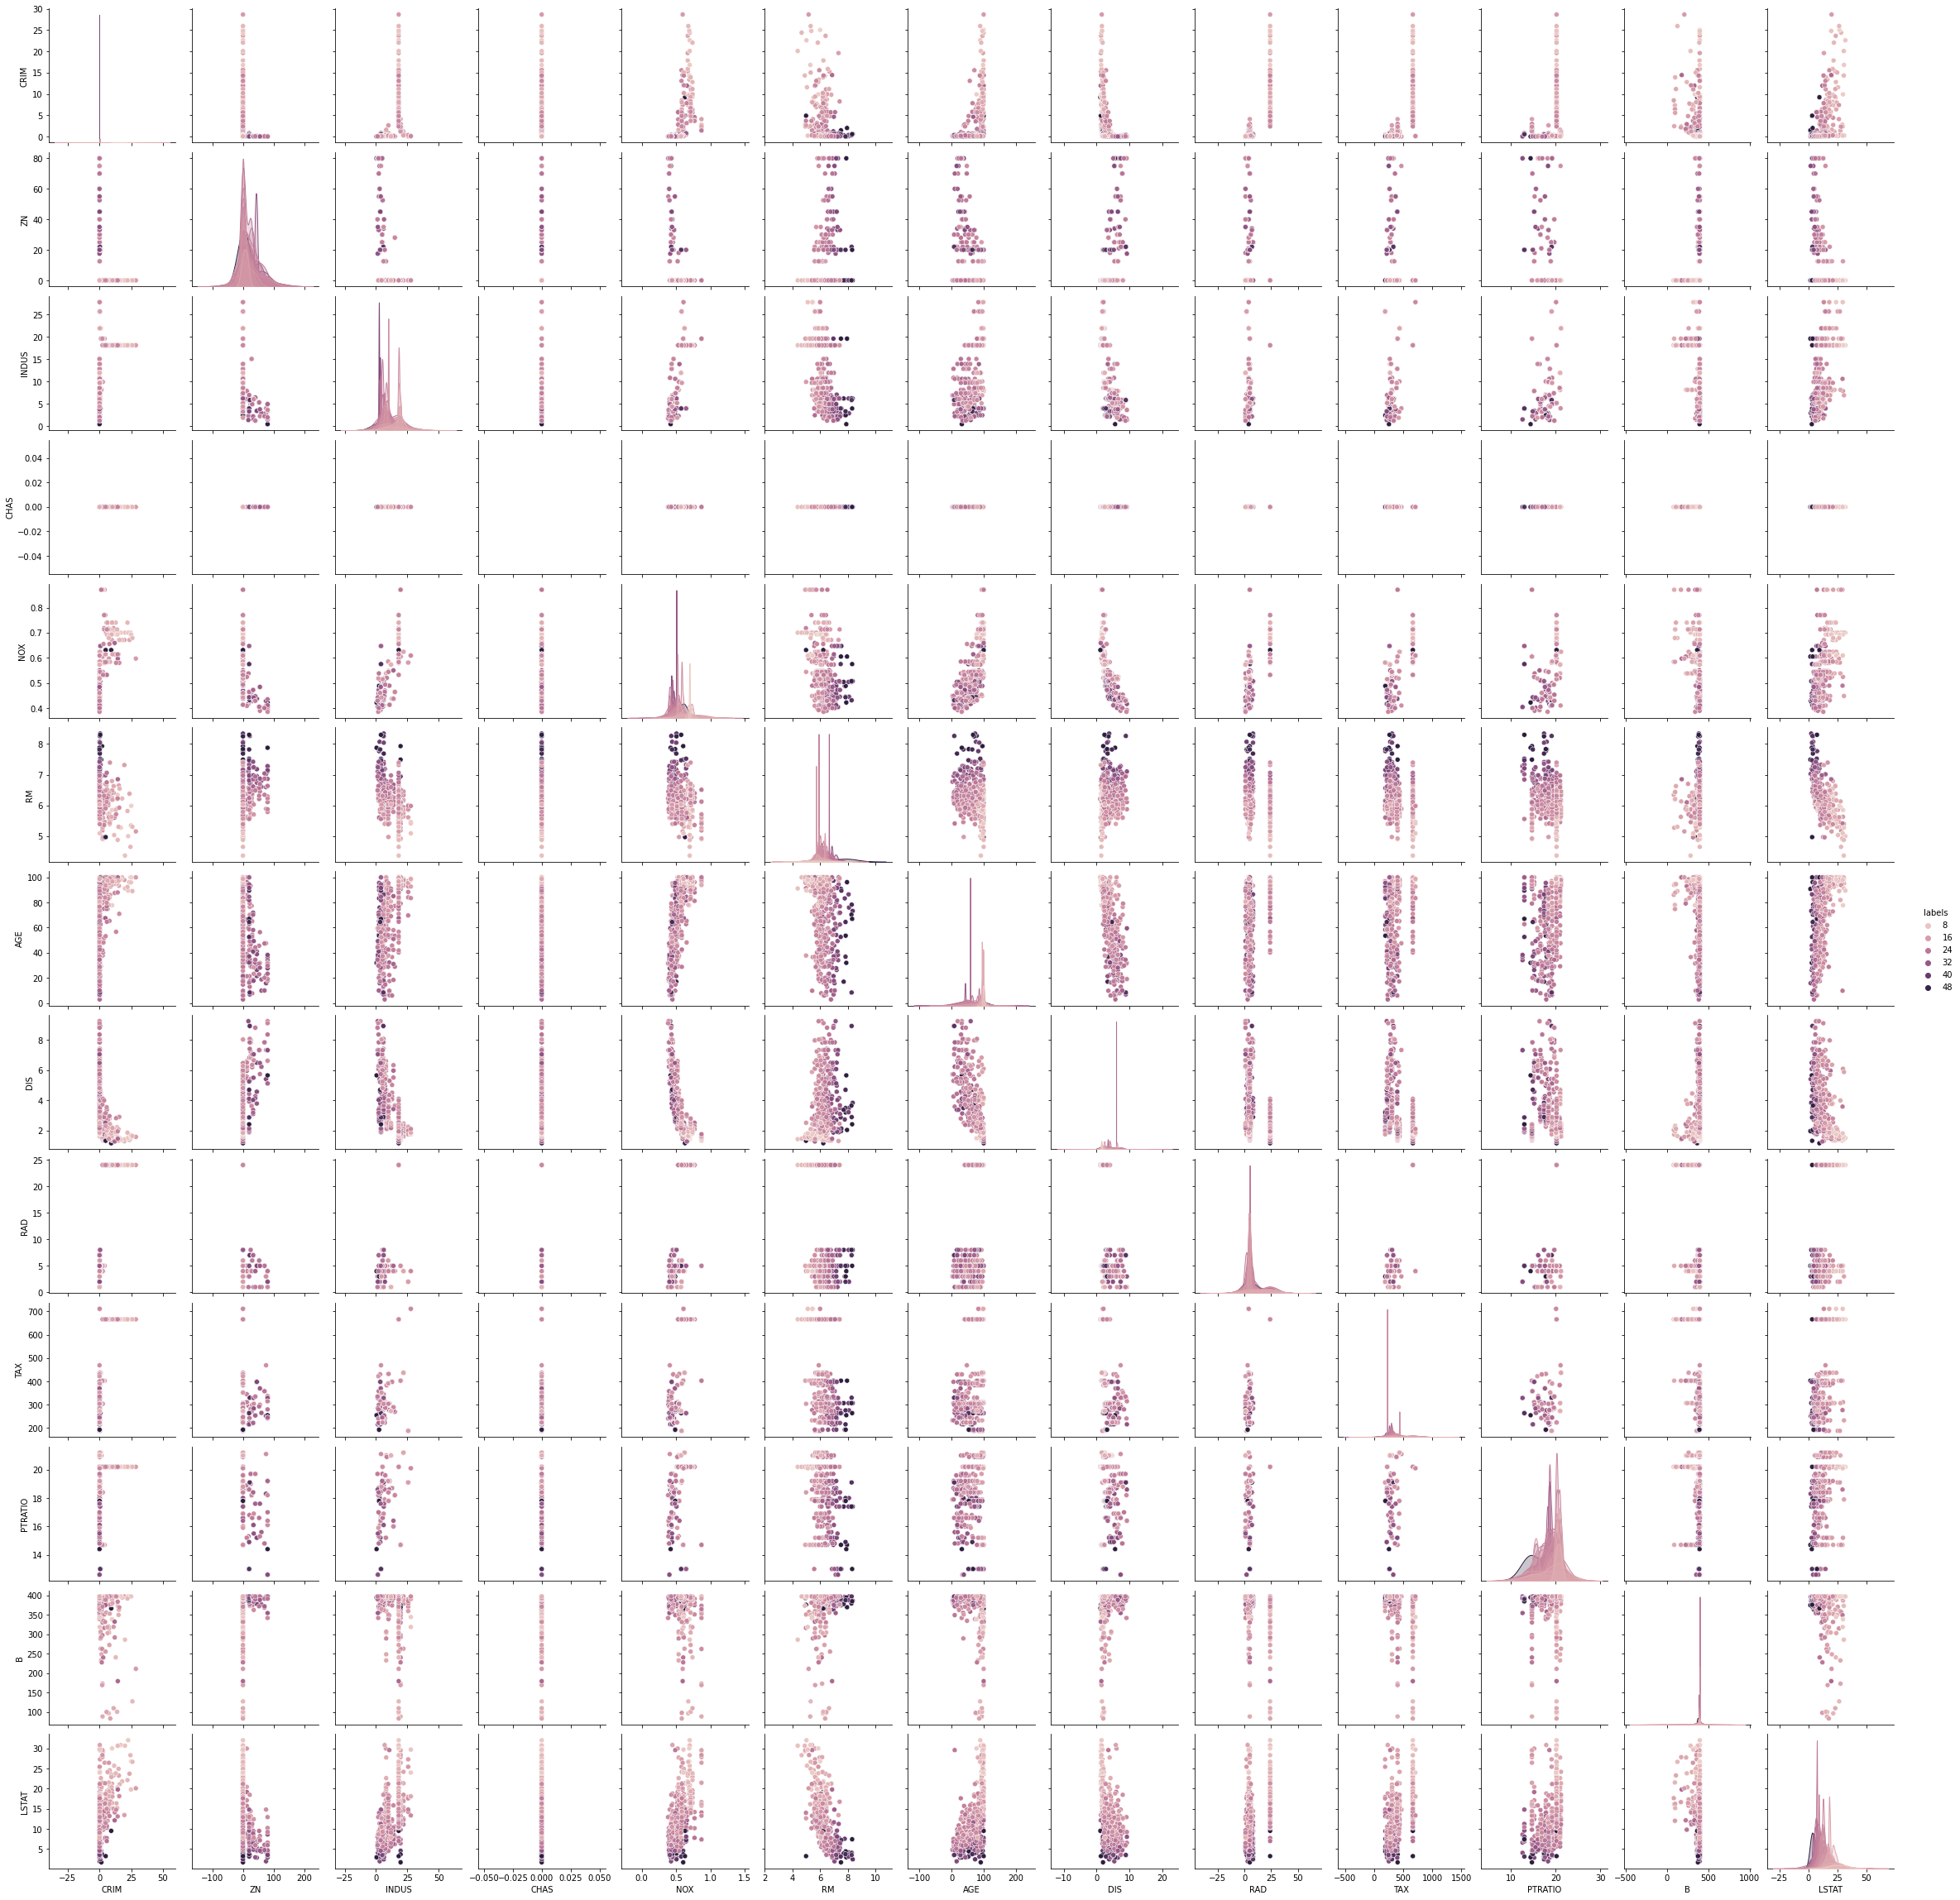

In [3]:
# Your plots here

# import seaborn
import seaborn as sns

# check pairplots
sns.pairplot(new_df, hue="labels")

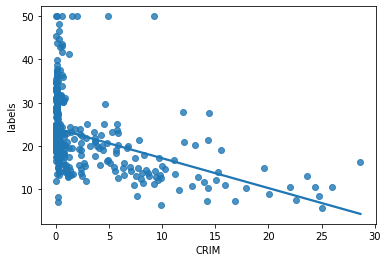

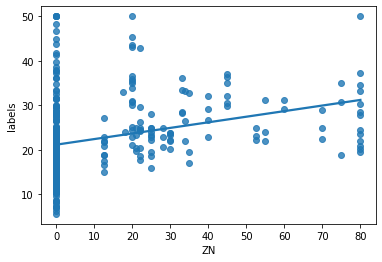

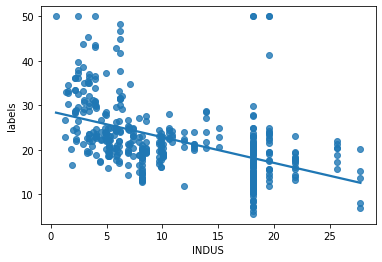

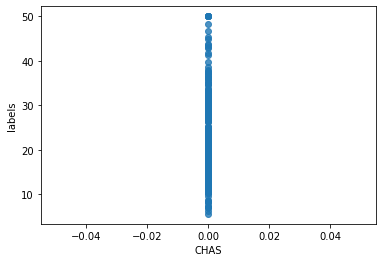

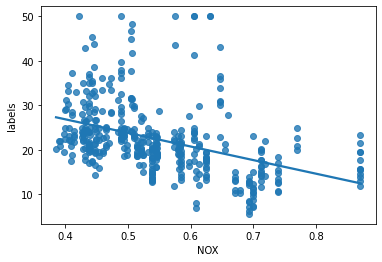

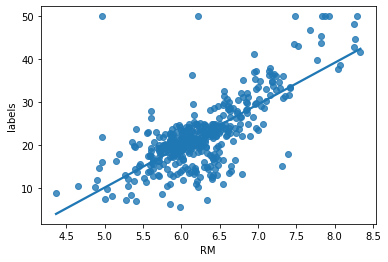

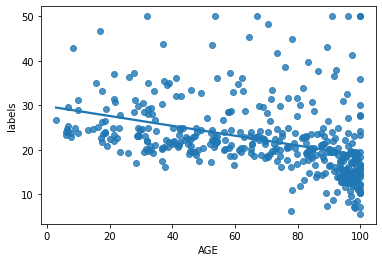

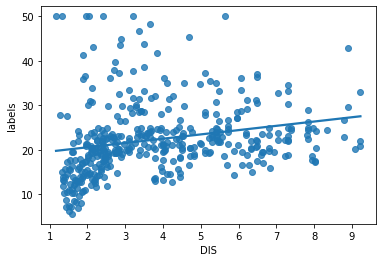

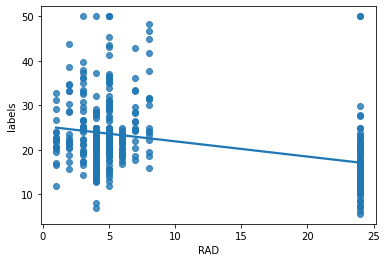

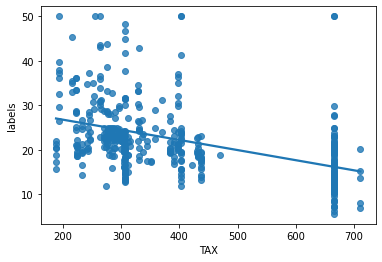

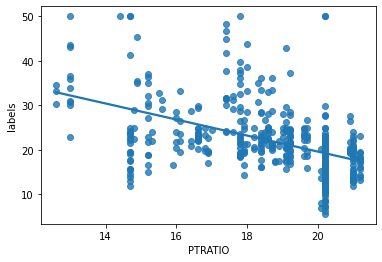

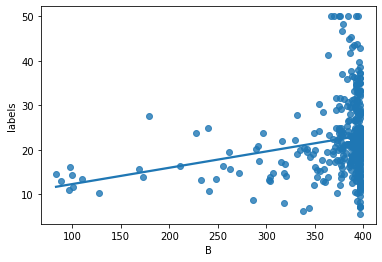

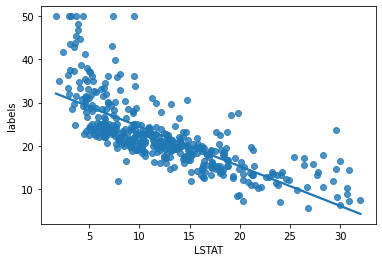

In [4]:
import matplotlib.pyplot as plt

y = "labels"
sns.regplot(x = "CRIM",
            y = y, 
            ci = None,
            data = new_df)
plt.show()
sns.regplot(x = "ZN",
            y = y, 
            ci = None,
            data = new_df)
plt.show()
sns.regplot(x = "INDUS",
            y = y, 
            ci = None,
            data = new_df)
plt.show()
sns.regplot(x = "CHAS",
            y = y, 
            ci = None,
            data = new_df)
plt.show()
sns.regplot(x = "NOX",
            y = y, 
            ci = None,
            data = new_df)
plt.show()
sns.regplot(x = "RM",
            y = y, 
            ci = None,
            data = new_df)
plt.show()
sns.regplot(x = "AGE",
            y = y, 
            ci = None,
            data = new_df)
plt.show()
sns.regplot(x = "DIS",
            y = y, 
            ci = None,
            data = new_df)
plt.show()
sns.regplot(x = "RAD",
            y = y, 
            ci = None,
            data = new_df)
plt.show()
sns.regplot(x = "TAX",
            y = y, 
            ci = None,
            data = new_df)
plt.show()
sns.regplot(x = "PTRATIO",
            y = y, 
            ci = None,
            data = new_df)
plt.show()
sns.regplot(x = "B",
            y = y, 
            ci = None,
            data = new_df)
plt.show()
sns.regplot(x = "LSTAT",
            y = y, 
            ci = None,
            data = new_df)
plt.show()

In [5]:
# check correlations with target
display(new_df.corrwith(new_df["labels"]))

# check correlations overall
display(new_df.corr())

CRIM      -0.418531
ZN         0.306172
INDUS     -0.486369
CHAS            NaN
NOX       -0.417222
RM         0.734041
AGE       -0.384446
DIS        0.234420
RAD       -0.347297
TAX       -0.453723
PTRATIO   -0.476781
B          0.234161
LSTAT     -0.738700
labels     1.000000
dtype: float64

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,labels
CRIM,1.000000,-0.235368,0.496014,NaN,0.543941,-0.256220,0.419317,-0.458391,0.797353,0.731316,0.322394,-0.306526,0.543535,-0.418531
ZN,-0.235368,1.000000,-0.482283,NaN,-0.484217,0.285338,-0.507627,0.601974,-0.265506,-0.277640,-0.400607,0.141924,-0.377615,0.306172
INDUS,0.496014,-0.482283,1.000000,NaN,0.734989,-0.395686,0.599328,-0.675009,0.548687,0.699422,0.361641,-0.316034,0.601658,-0.486369
CHAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOX,0.543941,-0.484217,0.734989,NaN,1.000000,-0.311671,0.719230,-0.772557,0.579036,0.644144,0.160670,-0.356332,0.604435,-0.417222
RM,-0.256220,0.285338,-0.395686,NaN,-0.311671,1.000000,-0.219932,0.195682,-0.171454,-0.269194,-0.309908,0.146503,-0.630955,0.734041
AGE,0.419317,-0.507627,0.599328,NaN,0.719230,-0.219932,1.000000,-0.719924,0.403405,0.474359,0.242456,-0.242556,0.603143,-0.384446
DIS,-0.458391,0.601974,-0.675009,NaN,-0.772557,0.195682,-0.719924,1.000000,-0.450038,-0.514232,-0.227957,0.250530,-0.478924,0.234420
RAD,0.797353,-0.265506,0.548687,NaN,0.579036,-0.171454,0.403405,-0.450038,1.000000,0.892011,0.408510,-0.285008,0.448428,-0.347297
TAX,0.731316,-0.277640,0.699422,NaN,0.644144,-0.269194,0.474359,-0.514232,0.892011,1.000000,0.404856,-0.314385,0.526334,-0.453723


### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [6]:
# Your response here

# The most correlated variables seem to be "LSTAT", "INDUS" and "CRIM". It makes sense to see variables like status and crime rate. 

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

<AxesSubplot:>

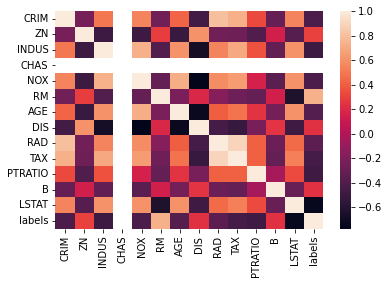

In [7]:
# Your response here

# heatmap
sns.heatmap(new_df.corr())

# It's interesting to see that it is the negative correaltions that seem most important. 

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [8]:
# Your code here

# decriptive stats for house price
display(new_df["labels"].describe())

count    415.000000
mean      22.353976
std        8.077366
min        5.600000
25%       17.550000
50%       21.200000
75%       24.800000
max       50.000000
Name: labels, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [9]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    
    return r2_score(y_true, y_predict)


### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [10]:
# Your code here

from sklearn.model_selection import train_test_split

features = new_df.drop(["labels"], axis=1)

labels = new_df["labels"]

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.25)

display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(311, 13)

(104, 13)

(311,)

(104,)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

Now, plot the score for each tree on the training set and on the testing set.

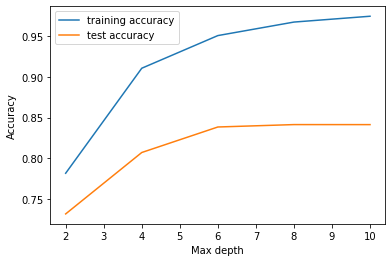

In [17]:
# Produce a plot with the score for the testing and training for the different max depths

# load algorithm
from sklearn.ensemble import RandomForestRegressor

# define list of max depths
max_depths = [2, 4, 6, 8, 10]

train_accuracy = []
test_accuracy = []

# train models and save results
for max_depth in max_depths:
    forest = RandomForestRegressor(max_depth=max_depth, random_state=1)
    forest.fit(X_train, y_train) 
    test_accuracy.append(forest.score(X_test, y_test))
    train_accuracy.append(forest.score(X_train, y_train))

plt.plot(max_depths, train_accuracy, label="training accuracy")
plt.plot(max_depths, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Max depth")
plt.legend()
plt.show()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [13]:
# Your response here

# The r2 score flattens out after max_depth=6 for both train and test. There is a large increase in r2 between 2 and 4 and between 4 and 6.

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [14]:
# Your response here

# A model with the maximum depth of 1 suffers from a high bias, paying little attention to the training data and oversimplifying the model.

# For a model with max_depth 10, it is the other way around. It suffers from high variance, paying too much attention to the training data. 

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [15]:
# Your response here

# Based on the graph before, I'd say that a model with max_depth 3 would be best. It does not suffer as much from overfitting as the models with greater depth. 

# define model
forest = RandomForestRegressor(max_depth=3, random_state=1)
forest.fit(X_train, y_train) 
display(forest.score(X_test, y_test))
display(forest.score(X_train, y_train))

# With amax depth of 3, it has a test r2 score of ~79 and a train r2 score of 87. It has too high variance still. 

0.7855395563371891

0.8743477695336672

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [16]:
# Your response here

# General answer
# There is probably a use case for the data we see here, but not for predicting the median value of hoses of today. It could however be part of a setting in which you want to see trends over time, in which case it can be combine with other data. 

#How relevant today is data that was collected from 1978?
# That is an empirical question, but probably not very relevant, considering how the demographic of cities change in general.

#Are the features present in the data sufficient to describe a home?
# The goal is to predict the value of the house. There could be more features that would be relevant. 

#Is the model robust enough to make consistent predictions?
# No. The data is very limited in size. 

#Would data collected in an urban city like Boston be applicable in a rural city?
# Probably not. There are different variables to take into consideration in a rural city. Such as for instance the distance to the nearest bigger city. 